This markdown covers the:
* data reading
* data imputation (optionnal)
* data preprocessing (i.e. compute informative variables)
* data one-hot encoding
* feature-scaling of the profile data frame
* dimensionality reduction of the profile dataframe
* modelling of the clusters using K-Means
* interpretation of the clusters

Author: Mickael Bastard

In [1]:
import numpy as np
import pandas as pd
import random
import imp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from yellowbrick.cluster.elbow import kelbow_visualizer

import sys
sys.path.insert(1, './../utils/')
# importing the utils_main library as utm
import utils_main as utm
import utils_pipeline as utpi
import utils_plots as utpl

from lifetimes.utils import summary_data_from_transaction_data

# 1. Preprocessing pipeline - call pipe_preProcessing() function

* data reading
* data imputation (optionnal)
* feature-engineering of the data (i.e. compute informative variables)
* one-hot encoding of the data

In [2]:
imp.reload(utpi)

<module 'utils_pipeline' from 'C:\\Users\\micka\\01_GitHub_mbastard\\TargetingCustomers_DAIB\\clustering\\./../utils\\utils_pipeline.py'>

In [3]:
portfolio, profile, transcript = utpi.pipe_preProcessing(dropUnnecessaryCol = False, impute = True, how = 'impute')

In [4]:
#profile.head()

In [5]:
#print(profile.isnull().sum())

Drop hot-encoded variables

In [6]:
profile = profile.drop(["year_joined", "gender", "became_member_on", "prep_tot_spend"], axis=1).copy()
#print(profile.isnull().sum())

# 2. Pre-Modelling pipeline - call pipe_preMod() function

* feature-scaling of the profile data frame
* dimensionality reduction of the profile dataframe

**Feature scaling**

"K-means clustering is "isotropic" in all directions of space and therefore tends to produce more or less round (rather than elongated) clusters. In this situation leaving variances unequal is equivalent to putting more weight on variables with smaller variance, so clusters will tend to be separated along variables with greater variance."

Standardize features by removing the mean and scaling to unit variance.

The standard score of a sample x is calculated as:

z = (x - u) / s

**Dimensionality reduction**

The k-means algorithm is both more effective and more efficient with a small number of dimensions, that is, the number of features used to predict the right cluster for each customer.

To reduce dimensionality, we can use Principal Component Analysis (PCA) — a method which identifies variables that are responsible for most of the variance in the data.

In [7]:
imp.reload(utpi)
imp.reload(utpl)

<module 'utils_plots' from 'C:\\Users\\micka\\01_GitHub_mbastard\\TargetingCustomers_DAIB\\clustering\\./../utils\\utils_plots.py'>

In [8]:
X_pca, pca = utpi.pipe_preMod(profile, var_explained=0.8)

In [9]:
X_pca.shape

(17000, 10)

X_pca is scaled and reduced to 10 dimensions -> will be used as input for the clustering

Explained variance per principal components

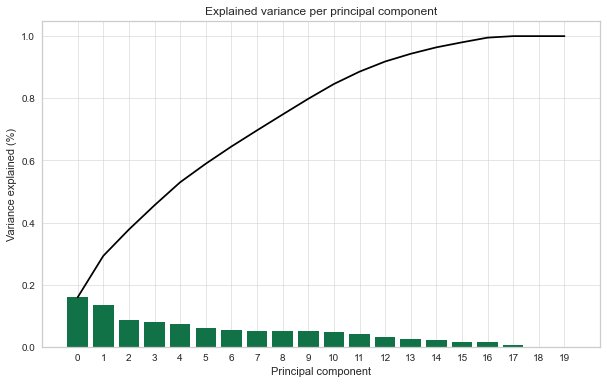

In [10]:
utpl.screePlot(profile, var_explained=0.8)

In [11]:
len(np.cumsum(pca.explained_variance_ratio_))

10

80% of the variance in explained by 10 components

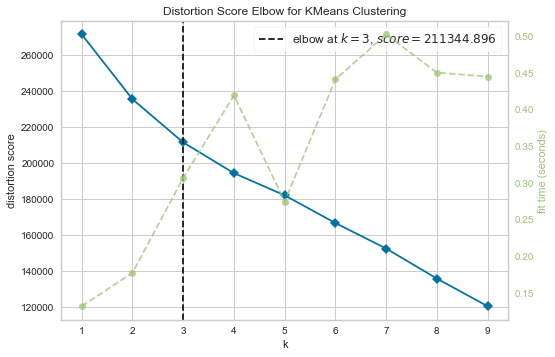

In [12]:
# elbow method
kelbow_visualizer(KMeans(), X_pca, k=(1,10));

In [13]:
# silhouette method
# kelbow_visualizer(KMeans(), X_pca, k=(2,10), metric='silhouette');

# 3. Modelling (Clustering with K-means)

In [14]:
imp.reload(utpi)
imp.reload(utpl)

<module 'utils_plots' from 'C:\\Users\\micka\\01_GitHub_mbastard\\TargetingCustomers_DAIB\\clustering\\./../utils\\utils_plots.py'>

Choose 3 clusters as the best number of clusters
Do not forget to use "1234" as seed

In [15]:
model = KMeans(n_clusters=3, random_state=utm.getSeed()).fit(X_pca)
kmeans_clusters = model.predict(X_pca)

# 4. Evaluation and Interpretation

In [16]:
imp.reload(utpi)
imp.reload(utpl)

<module 'utils_plots' from 'C:\\Users\\micka\\01_GitHub_mbastard\\TargetingCustomers_DAIB\\clustering\\./../utils\\utils_plots.py'>

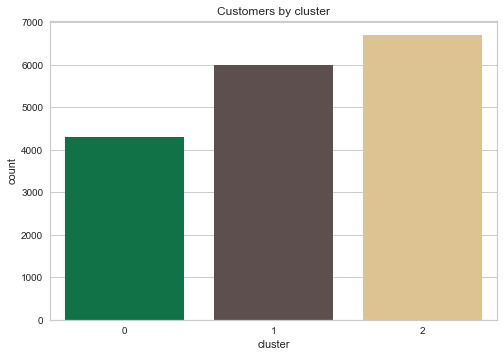

In [17]:
utpl.customersByClusters(profile, kmeans_clusters)

In [18]:
df = profile.copy()
df['cluster'] = kmeans_clusters
df = df.melt(id_vars=['id_membership', 'cluster'])
df = df.query('cluster != -1').groupby(['cluster', 'variable']).mean().reset_index()
df.head()

,cluster,variable,value
0,0,age,55.731385
1,0,gender_F,0.286446
2,0,gender_M,0.694457
3,0,gender_O,0.019096
4,0,income,63274.956483


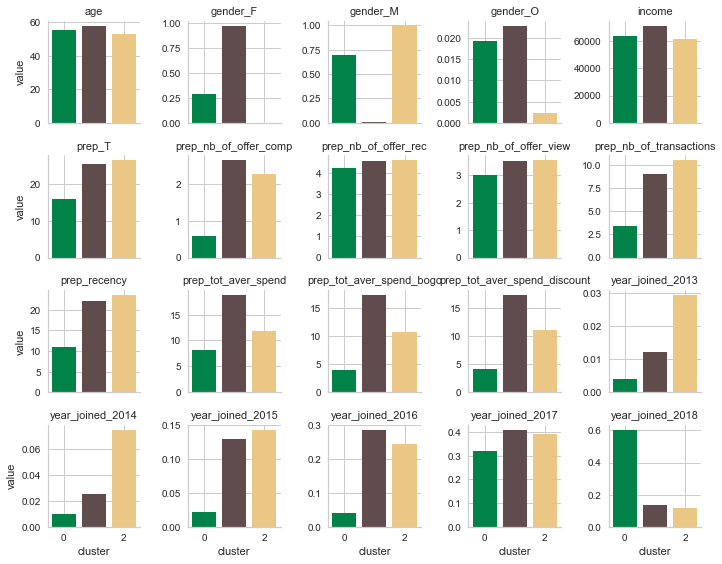

In [19]:
utpl.barPlotGrid(profile, kmeans_clusters)

## Brown Group - Women who spend a lot and complete a lot of offers
* Mainly Women (almost 100%)
* 2 to 4 years of seniority (joined mostly between 2015 and 2017)
* High recency (More than 20 days)
* High total average spend (i.e. around 20 dollars)
* High total average spend on bogo and discount offers (i.e. around 20 dollars)
* High number of offer completed (i.e. around 3)
* High number of transactions (i.e. more than 7)

## Green Group - Mostly men not completing offers, and spending less when they use offers, who joined less than 2 years ago (i.e. low seniority)
* Mainly Men (75% of men and 25% of women)
* Joined lately in 2017 and 2018 (90% of them)
* Low recency (about 10 days) --> joined less than 2 years ago
* Low total average spend (i.e. less than 10 dollar)
* Low total average spend on bogo and discount (i.e. 5 dollar)
* --> spend less when they use bogo and discount offers (5<10)
* Low number of offer completed (i.e. less than one)
* Low number of transactions (i.e. around 3)

## Yellow Group - Men spending on average always the same even if they do not receive offers
* Mainly Men (almost 100%)
* Has more than one year seniority
* High recency (More than 20 days)
* Medium total average spend (i.e. around 12 dollars)
* Medium total average spend on bogo and discount offers (i.e. around 12 dollars)
* --> Spend the same when they complete bogo and discount offers
* Medium number of offer completed (i.e. around 2.5)
* High number of transactions (i.e. more than 10)